INFO:__main__:Using device: cuda


Using downloaded and verified file: VOC\VOCtrainval_06-Nov-2007.tar
Extracting VOC\VOCtrainval_06-Nov-2007.tar to VOC
down_ratio = 4
loss_dict = {}


C:\Users\fight\AppData\Local\Temp\ipykernel_10220\1223175279.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

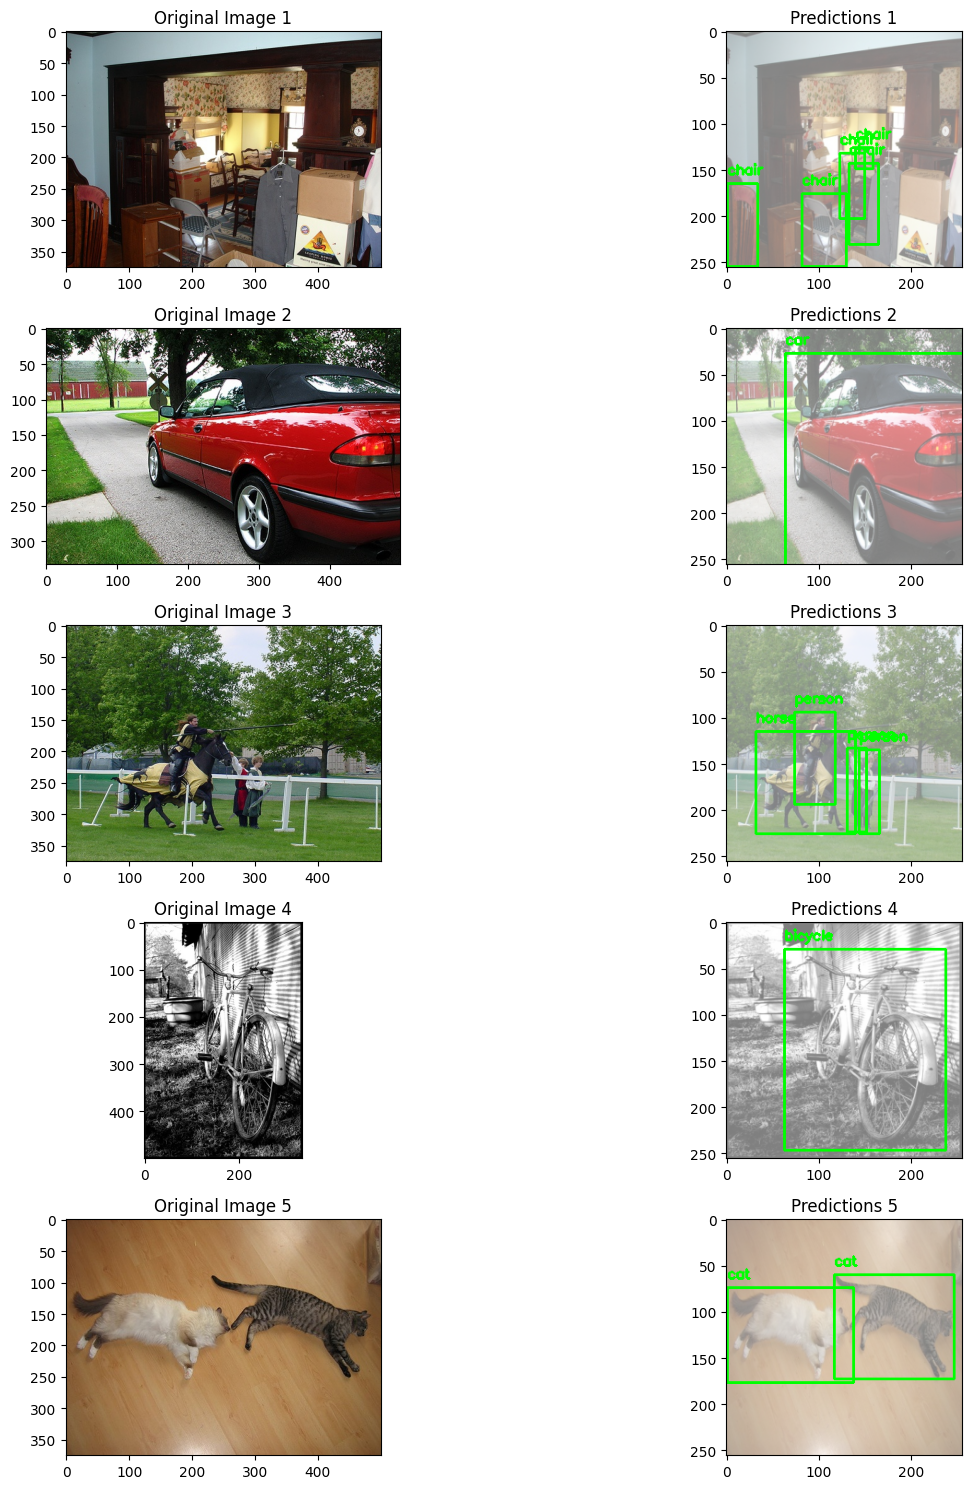

In [5]:
import os
import torch
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import custom modules
from encoder import CenternetEncoder
from postprocess import CenternetPostprocess
from visualizer import get_image_with_bboxes, PASCAL_CLASSES
from od_from_scratch import ModelBuilder

def prepare_dataset():
    """Prepare the validation dataset"""
    try:
        # Load VOC dataset
        dataset_val = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set="val", download=True)
        dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)

        # Select first 30 indices for visualization
        indices = list(range(min(30, len(dataset_val))))
        dataset_val = Subset(dataset_val, indices)

        return dataset_val
    except Exception as e:
        logger.error(f"Error preparing dataset: {e}")
        raise

def create_transforms(input_height=256, input_width=256):
    """Create image transforms"""
    return transforms.Compose([
        transforms.Resize(size=(input_width, input_height)),
        transforms.ToTensor()
    ])

def load_trained_model(checkpoint_path, device):
    """Load the trained CenterNet model"""
    try:
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

        model = ModelBuilder(alpha=0.25).to(device)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.eval()
        return model
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        raise

def visualize_predictions(model, dataset, transform, encoder, postprocessor, device, num_samples=5, confidence_threshold=0.3):
    """Visualize model predictions"""
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(min(num_samples, len(dataset))):
        # Get original image and ground truth
        orig_img, orig_label = dataset[i]

        # Apply transforms
        img, bboxes, labels = transform(orig_img, orig_label['boxes'], orig_label['labels'])
        img = img.unsqueeze(0).to(device)

        # Inference
        with torch.no_grad():
            pred = model(img)

        # Postprocess predictions
        detections = postprocessor(pred)

        # Convert to numpy for processing
        img_np = np.transpose(img.cpu().squeeze().numpy(), (1, 2, 0))
        img_np = (img_np * 0.5) + 0.5  # Denormalize
        img_np = np.clip(img_np, 0, 1)

        # Reconstruct bounding boxes
        img_h, img_w = img_np.shape[:2]
        pred_boxes = []
        pred_labels = []

        for det in detections[0]:
            class_id = int(det[0].item())
            score = det[1].item()

            # Only process detections with reasonable confidence
            if score > confidence_threshold:
                x1 = int(det[2].item() * img_w)
                y1 = int(det[3].item() * img_h)
                x2 = int(det[4].item() * img_w)
                y2 = int(det[5].item() * img_h)

                pred_boxes.append([x1, y1, x2, y2])
                pred_labels.append(class_id)

        # Visualize
        plt.subplot(num_samples, 2, 2*i+1)
        plt.title(f'Original Image {i+1}')
        plt.imshow(orig_img)

        plt.subplot(num_samples, 2, 2*i+2)
        plt.title(f'Predictions {i+1}')
        img_with_pred = img_np.copy()

        # Draw predicted bounding boxes
        for box, label in zip(pred_boxes, pred_labels):
            cv2.rectangle(img_with_pred,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 255, 0), 2)
            # Add class label
            cv2.putText(img_with_pred,
                        PASCAL_CLASSES[label-1],
                        (box[0], box[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 255, 0), 2)

        plt.imshow(img_with_pred)

    plt.tight_layout()
    plt.show()

def main():
    try:
        # Device configuration
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {device}")

        # Hyperparameters
        input_height = input_width = 256
        down_ratio = 4
        checkpoint_path = 'model_checkpoints/pascal_voc_final_weights.pt'

        # Prepare components
        dataset = prepare_dataset()
        transform = create_transforms(input_height, input_width)
        encoder = CenternetEncoder(input_height, input_width)
        postprocessor = CenternetPostprocess(n_classes=20, width=input_width, height=input_height, down_ratio=down_ratio).to(device)

        # Load trained model
        model = load_trained_model(checkpoint_path, device)

        # Visualize predictions
        visualize_predictions(model, dataset, transform, encoder, postprocessor, device)

    except Exception as e:
        logger.error(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

down_ratio = 4
Using downloaded and verified file: VOC\VOCtrainval_06-Nov-2007.tar
Extracting VOC\VOCtrainval_06-Nov-2007.tar to VOC
loss_dict = {}
Model Output Tensor Shape: torch.Size([1, 24, 64, 64])

Tensor Detailed Breakdown:
Channels 0-19 (Class Heatmaps): torch.Size([20, 64, 64])
Channels 20-23 (Bbox Coordinates): torch.Size([4, 64, 64])

Bounding Box Coordinates:
X Center:
[[ 2.2103071   0.48275337  1.2561731  ...  7.515737    6.5686054
   4.078468  ]
 [ 4.536494    2.3377008   3.4794884  ...  7.399813    5.0424075
   3.9019406 ]
 [ 2.143537    1.8560333   5.371629   ...  0.7739471   0.4308465
   0.72313184]
 ...
 [ 0.42189437  0.10997322  1.259524   ...  0.5154332  -0.31857774
   0.6324939 ]
 [ 6.49311     5.0799947   5.690301   ...  3.9351761   2.6746156
   1.236643  ]
 [ 3.2956324   2.6807706   4.601536   ...  4.2436547   2.4469373
   2.7041454 ]]
Y Center:
[[ 5.630361    1.0187705   0.22956005 ...  9.38848     9.254385
   5.571993  ]
 [10.021259    0.12447537  2.0933273  ..

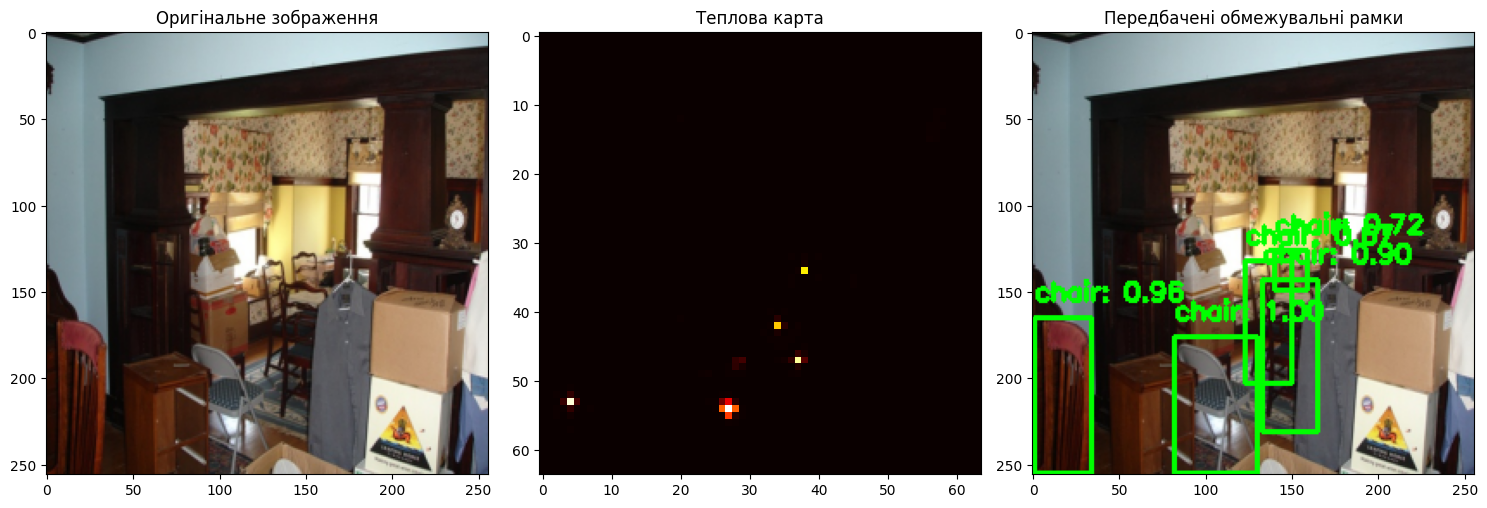

In [15]:
import torch
import torchvision
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

from loss import CenternetTTFLoss
from encoder import CenternetEncoder
from postprocess import CenternetPostprocess
from visualizer import PASCAL_CLASSES
from od_from_scratch import ModelBuilder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
def load_model(checkpoint_path):
    model = ModelBuilder(alpha=0.25).to(device)
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True, map_location=device))
    model.eval()  # Set to evaluation mode
    return model

# Prepare dataset and transformation
input_height = input_width = 256
encoder = CenternetEncoder(input_height, input_width)
transform = transforms.Compose([
    transforms.Resize(size=(input_width, input_height)),
    transforms.ToTensor()
])

# Load VOC validation dataset
dataset_val = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set="val", download=True)
dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)

# Select a specific image
image_index = 0  # Change this to select different images
img, original_annotation = dataset_val[image_index]

# Transform the image
img_transformed, bboxes, labels = transform(img,
    original_annotation['boxes'],
    original_annotation['labels']
)

# Load the model
checkpoint_path = 'model_checkpoints/pascal_voc_final_weights.pt'
model = load_model(checkpoint_path)

# Postprocessing
postprocessor = CenternetPostprocess(n_classes=20, width=input_width, height=input_height)

def extract_and_visualize_results(img_transformed, model, postprocessor):

    img_input = img_transformed.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_input)

        # Print output tensor details
        print("Model Output Tensor Shape:", output.shape)
        print("\nTensor Detailed Breakdown:")
        print("Channels 0-19 (Class Heatmaps):", output[0, :20].shape)
        print("Channels 20-23 (Bbox Coordinates):", output[0, 20:24].shape)

        bbox_coords = output[0, 20:24]
        print("\nBounding Box Coordinates:")
        for i, coord_type in enumerate(['X Center', 'Y Center', 'Width', 'Height']):
            print(f"{coord_type}:")
            print(bbox_coords[i].cpu().numpy())

        detections = postprocessor(output)

# Prepare for visualization
def visualize_results(img_transformed, model, postprocessor):
    img_input = img_transformed.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_input)
        detections = postprocessor(output)

    detections_np = detections[0].cpu().numpy()

    confidence_threshold = 0.5
    valid_detections = detections_np[detections_np[:, 1] > confidence_threshold]

    img_for_cv = img_transformed.permute(1, 2, 0).numpy()
    img_for_cv = (img_for_cv * 255).astype(np.uint8)

    img_for_cv = cv2.cvtColor(img_for_cv, cv2.COLOR_RGB2BGR)

    for detection in valid_detections:
        class_id = int(detection[0]) - 1
        x1, y1, x2, y2 = detection[2:6]

        x1 = int(x1 * input_width)
        y1 = int(y1 * input_height)
        x2 = int(x2 * input_width)
        y2 = int(y2 * input_height)

        cv2.rectangle(img_for_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)

        class_name = PASCAL_CLASSES[class_id]
        cv2.putText(img_for_cv,
                    f'{class_name}: {detection[1]:.2f}',
                    (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (0, 255, 0),
                    2)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title('Оригінальне зображення')
    plt.imshow(img_transformed.permute(1,2,0))

    heatmap = output[0, :20, :, :].max(dim=0)[0].cpu().numpy()
    plt.subplot(1,3,2)
    plt.title('Теплова карта')
    plt.imshow(heatmap, cmap='hot')

    plt.subplot(1,3,3)
    plt.title('Передбачені обмежувальні рамки')
    plt.imshow(cv2.cvtColor(img_for_cv, cv2.COLOR_BGR2RGB))

    plt.tight_layout()
    plt.show()

extract_and_visualize_results(img_transformed, model, postprocessor)

visualize_results(img_transformed, model, postprocessor)